In [1]:
from numpy import array, zeros
import numpy as np
import os
from os.path import join
from PIL import Image
import csv
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

In [0]:
def load_imgs_and_keypoints(dirname='facial_data/data/images'):
    imgs = []
    csvfile = csv.reader(open('facial_data/data/gt.csv', newline=''))
    points = []
    for row in csvfile:
        if row[0] == 'filename':
            continue
        else:
            path = os.path.join(dirname, row[0])
            test = Image.open(path, mode='r')
            test = test.convert('RGB')
            (imgW, imgH) = test.size
            test_ary = test.resize((100,100), resample=0)
            if np.asarray(test_ary).shape != (100, 100, 3):
                print(path)
            imgs.append(np.asarray(test_ary))
            test.close()
            for i in range(14):
                row[2*i+1]   = int(row[2*i+1])/imgW - 0.5
                row[2*i+2] = int(row[2*i+2])/imgH - 0.5
            points.append(row[1:])
    return np.asarray(imgs), np.asarray(points)

imgs, points = load_imgs_and_keypoints()

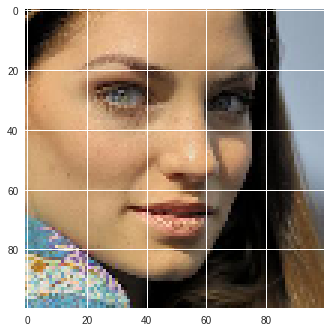

[-0.30534351 -0.30534351 -0.01526718 -0.27099237  0.14503817 -0.2519084
  0.27480916 -0.30152672 -0.24045802 -0.20610687 -0.17557252 -0.21374046
 -0.08015267 -0.1870229   0.11068702 -0.16793893  0.15267176 -0.19847328
  0.23664122 -0.17938931  0.09541985  0.04961832 -0.14885496  0.16412214
  0.03435115  0.1870229   0.14122137  0.18320611]
(6000, 100, 100, 3)
(6000, 28)


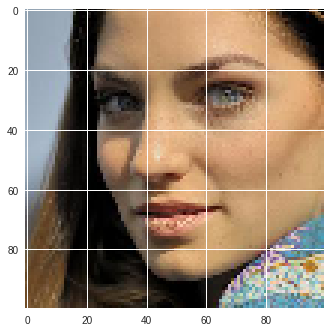

In [8]:
plt.imshow(imgs[0])
plt.show()
print(points[0])
print(imgs.shape)
print(points.shape)
plt.imshow(np.fliplr(imgs[0]))
plt.show()

In [ ]:
from matplotlib.patches import Circle

def visualize_points(img, points):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for i in range(len(points)//2):
        circ = Circle(((points[2*i]+0.5)*100,(points[2*i+1]+0.5)*100),1.5)
        #print(circ)
        ax.add_patch(circ)
    plt.show()
    pass
    
visualize_points(imgs[3], points[3])

In [ ]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

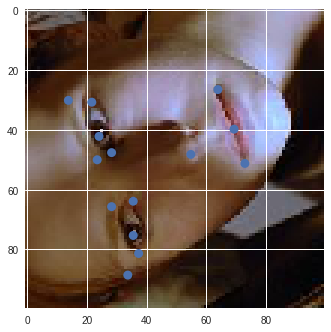

In [87]:
def flip_img2(img, points):
    # Write your code for flipping here
    f_points = [0 for i in range(len(points))]
    for i in range(len(points)//2):
        f_points[2*i] =  points[2*i]
        f_points[2*i+1] = - points[2*i+1]
    return np.flipud(img), f_points
f_img, f_points = flip_img2(imgs[2], points[2])
visualize_points(f_img, f_points)

In [74]:
aug_imgs_train, aug_points_train = [], []
for img, point in zip(imgs_train, points_train):
    f_img, f_points = flip_img2(img, point)
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
aug_imgs_train = np.array(aug_imgs_train)
aug_points_train = np.array(aug_points_train)
print(aug_imgs_train.shape)
print(aug_points_train.shape)

(5400, 100, 100, 3)
(5400, 28)


In [10]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Activation
)
from keras.layers.advanced_activations import LeakyReLU

In [11]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from keras import backend as K

In [7]:
def build_model():
    model = Sequential()
    # Define here your model
    model.add(Conv2D(filters=16, kernel_size = (3,3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(rate=0.25))
     
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(rate=0.2))

    model.add(Conv2D(filters=128, kernel_size = (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(rate=0.25))

    model.add(Flatten())
    
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(rate=0.25))

    #model.add(Dense(1000))
    #model.add(Activation('relu'))
    #model.add(Dropout(rate=0.25))
    
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(rate=0.25))
    
    model.add(Dense(28))
    #model.add(Activation('relu'))
    #model.add(Dropout(rate=0.25))
    
    return model

In [ ]:
BATCH_SIZE = 256
last_finished_epoch = None
model_filename = 'model/facial_key_2.hdf5'
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [12]:
K.clear_session()
model = build_model()
print(model.summary())
model.compile(
    loss='mean_squared_error',  
    optimizer='adam',
    metrics=['acc']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
__________

In [93]:
checkpointer = ModelCheckpoint(filepath=model_filename, monitor='val_loss', verbose=1, save_best_only=True)
model_history = model.fit(
    all_imgs_train, all_points_train,  
    batch_size = BATCH_SIZE,
    epochs = 1000,
    callbacks = [checkpointer],
    validation_data=(imgs_val, points_val)
)

Train on 10800 samples, validate on 600 samples
Epoch 1/1000
10800/10800 [==============================] - 6s 513us/step - loss: 65.7826 - acc: 0.0457 - val_loss: 0.0384 - val_acc: 0.0800

Epoch 00001: val_loss improved from inf to 0.03839, saving model to model/facial_key_2.hdf5
Epoch 2/1000
10800/10800 [==============================] - 5s 456us/step - loss: 0.0302 - acc: 0.2387 - val_loss: 0.0279 - val_acc: 0.6683

Epoch 00002: val_loss improved from 0.03839 to 0.02789, saving model to model/facial_key_2.hdf5
Epoch 3/1000
10800/10800 [==============================] - 5s 457us/step - loss: 0.0259 - acc: 0.3741 - val_loss: 0.0216 - val_acc: 0.6883

Epoch 00003: val_loss improved from 0.02789 to 0.02159, saving model to model/facial_key_2.hdf5
Epoch 4/1000
10800/10800 [==============================] - 5s 455us/step - loss: 0.0233 - acc: 0.3555 - val_loss: 0.0213 - val_acc: 0.7017

Epoch 00004: val_loss improved from 0.02159 to 0.02132, saving model to model/facial_key_2.hdf5
Epoch 5

 8192/10800 [=====================>........] - ETA: 1s - loss: 0.0063 - acc: 0.447310800/10800 [==============================] - 5s 460us/step - loss: 0.0063 - acc: 0.4420 - val_loss: 0.0046 - val_acc: 0.7817

Epoch 00037: val_loss did not improve from 0.00426
Epoch 38/1000
10800/10800 [==============================] - 5s 462us/step - loss: 0.0061 - acc: 0.4454 - val_loss: 0.0050 - val_acc: 0.7750

Epoch 00038: val_loss did not improve from 0.00426
Epoch 39/1000
10800/10800 [==============================] - 5s 460us/step - loss: 0.0061 - acc: 0.4436 - val_loss: 0.0040 - val_acc: 0.7800

Epoch 00039: val_loss improved from 0.00426 to 0.00399, saving model to model/facial_key_2.hdf5
Epoch 40/1000
10800/10800 [==============================] - 5s 460us/step - loss: 0.0060 - acc: 0.4452 - val_loss: 0.0041 - val_acc: 0.7833

Epoch 00040: val_loss did not improve from 0.00399
Epoch 41/1000
 9728/10800 [==========================>...] - ETA: 0s - loss: 0.0058 - acc: 0.448210800/10800 [====


Epoch 00077: val_loss did not improve from 0.00262
Epoch 78/1000
10800/10800 [==============================] - 5s 458us/step - loss: 0.0039 - acc: 0.5079 - val_loss: 0.0031 - val_acc: 0.7950

Epoch 00078: val_loss did not improve from 0.00262
Epoch 79/1000
10800/10800 [==============================] - 5s 460us/step - loss: 0.0040 - acc: 0.5046 - val_loss: 0.0030 - val_acc: 0.7900

Epoch 00079: val_loss did not improve from 0.00262
Epoch 80/1000
10800/10800 [==============================] - 5s 460us/step - loss: 0.0039 - acc: 0.5080 - val_loss: 0.0029 - val_acc: 0.7883

Epoch 00080: val_loss did not improve from 0.00262
Epoch 81/1000
10800/10800 [==============================] - 5s 460us/step - loss: 0.0039 - acc: 0.5035 - val_loss: 0.0027 - val_acc: 0.7933

Epoch 00081: val_loss did not improve from 0.00262
Epoch 82/1000
 6144/10800 [================>.............] - ETA: 2s - loss: 0.0038 - acc: 0.513810800/10800 [==============================] - 5s 459us/step - loss: 0.0039 - a

10240/10800 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 0.543610800/10800 [==============================] - 5s 458us/step - loss: 0.0029 - acc: 0.5455 - val_loss: 0.0023 - val_acc: 0.7883

Epoch 00119: val_loss did not improve from 0.00221
Epoch 120/1000
10800/10800 [==============================] - 5s 459us/step - loss: 0.0029 - acc: 0.5514 - val_loss: 0.0028 - val_acc: 0.7867

Epoch 00120: val_loss did not improve from 0.00221
Epoch 121/1000
10800/10800 [==============================] - 5s 461us/step - loss: 0.0029 - acc: 0.5373 - val_loss: 0.0025 - val_acc: 0.7883

Epoch 00121: val_loss did not improve from 0.00221
Epoch 122/1000
10800/10800 [==============================] - 5s 457us/step - loss: 0.0029 - acc: 0.5326 - val_loss: 0.0026 - val_acc: 0.7933

Epoch 00122: val_loss did not improve from 0.00221
Epoch 123/1000
10800/10800 [==============================] - 5s 457us/step - loss: 0.0029 - acc: 0.5460 - val_loss: 0.0024 - val_acc: 0.7950

Epoch 00123: 

10496/10800 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.557210800/10800 [==============================] - 5s 458us/step - loss: 0.0024 - acc: 0.5587 - val_loss: 0.0022 - val_acc: 0.8017

Epoch 00159: val_loss did not improve from 0.00207
Epoch 160/1000
10800/10800 [==============================] - 5s 457us/step - loss: 0.0025 - acc: 0.5620 - val_loss: 0.0022 - val_acc: 0.8067

Epoch 00160: val_loss did not improve from 0.00207
Epoch 161/1000
10800/10800 [==============================] - 5s 458us/step - loss: 0.0025 - acc: 0.5626 - val_loss: 0.0024 - val_acc: 0.7917

Epoch 00161: val_loss did not improve from 0.00207
Epoch 162/1000
10800/10800 [==============================] - 5s 457us/step - loss: 0.0024 - acc: 0.5631 - val_loss: 0.0022 - val_acc: 0.8150

Epoch 00162: val_loss did not improve from 0.00207
Epoch 163/1000
10800/10800 [==============================] - 5s 458us/step - loss: 0.0024 - acc: 0.5688 - val_loss: 0.0020 - val_acc: 0.8133

Epoch 00163: 

10800/10800 [==============================] - 5s 458us/step - loss: 0.0022 - acc: 0.5892 - val_loss: 0.0018 - val_acc: 0.8217

Epoch 00199: val_loss did not improve from 0.00173
Epoch 200/1000
10800/10800 [==============================] - 5s 456us/step - loss: 0.0021 - acc: 0.5899 - val_loss: 0.0023 - val_acc: 0.7867

Epoch 00200: val_loss did not improve from 0.00173
Epoch 201/1000
10800/10800 [==============================] - 5s 458us/step - loss: 0.0022 - acc: 0.5935 - val_loss: 0.0020 - val_acc: 0.8150

Epoch 00201: val_loss did not improve from 0.00173
Epoch 202/1000
10800/10800 [==============================] - 5s 458us/step - loss: 0.0021 - acc: 0.5960 - val_loss: 0.0019 - val_acc: 0.8167

Epoch 00202: val_loss did not improve from 0.00173
Epoch 203/1000
 6912/10800 [==================>...........] - ETA: 1s - loss: 0.0022 - acc: 0.588410800/10800 [==============================] - 5s 455us/step - loss: 0.0022 - acc: 0.5879 - val_loss: 0.0018 - val_acc: 0.8017

Epoch 00203: 

10800/10800 [==============================] - 5s 457us/step - loss: 0.0019 - acc: 0.6167 - val_loss: 0.0017 - val_acc: 0.8217

Epoch 00239: val_loss did not improve from 0.00164
Epoch 240/1000
10800/10800 [==============================] - 5s 456us/step - loss: 0.0019 - acc: 0.6191 - val_loss: 0.0017 - val_acc: 0.8183

Epoch 00240: val_loss did not improve from 0.00164
Epoch 241/1000
10800/10800 [==============================] - 5s 456us/step - loss: 0.0019 - acc: 0.6144 - val_loss: 0.0022 - val_acc: 0.8183

Epoch 00241: val_loss did not improve from 0.00164
Epoch 242/1000
10800/10800 [==============================] - 5s 456us/step - loss: 0.0020 - acc: 0.6101 - val_loss: 0.0019 - val_acc: 0.8100

Epoch 00242: val_loss did not improve from 0.00164
Epoch 243/1000
 6912/10800 [==================>...........] - ETA: 1s - loss: 0.0019 - acc: 0.626310800/10800 [==============================] - 5s 456us/step - loss: 0.0019 - acc: 0.6172 - val_loss: 0.0018 - val_acc: 0.8167

Epoch 00243: 

10800/10800 [==============================] - 5s 456us/step - loss: 0.0017 - acc: 0.6315 - val_loss: 0.0018 - val_acc: 0.8233

Epoch 00279: val_loss did not improve from 0.00155
Epoch 280/1000
10800/10800 [==============================] - 5s 455us/step - loss: 0.0017 - acc: 0.6376 - val_loss: 0.0017 - val_acc: 0.8233

Epoch 00280: val_loss did not improve from 0.00155
Epoch 281/1000
10800/10800 [==============================] - 5s 455us/step - loss: 0.0017 - acc: 0.6312 - val_loss: 0.0018 - val_acc: 0.8267

Epoch 00281: val_loss did not improve from 0.00155
Epoch 282/1000
10800/10800 [==============================] - 5s 454us/step - loss: 0.0017 - acc: 0.6283 - val_loss: 0.0018 - val_acc: 0.8200

Epoch 00282: val_loss did not improve from 0.00155
Epoch 283/1000
 6912/10800 [==================>...........] - ETA: 1s - loss: 0.0016 - acc: 0.629510800/10800 [==============================] - 5s 455us/step - loss: 0.0016 - acc: 0.6348 - val_loss: 0.0017 - val_acc: 0.8233

Epoch 00283: 

 6912/10800 [==================>...........] - ETA: 1s - loss: 0.0015 - acc: 0.639910800/10800 [==============================] - 5s 453us/step - loss: 0.0015 - acc: 0.6439 - val_loss: 0.0016 - val_acc: 0.8200

Epoch 00319: val_loss did not improve from 0.00143
Epoch 320/1000
10800/10800 [==============================] - 5s 454us/step - loss: 0.0015 - acc: 0.6457 - val_loss: 0.0015 - val_acc: 0.8267

Epoch 00320: val_loss did not improve from 0.00143
Epoch 321/1000
10800/10800 [==============================] - 5s 455us/step - loss: 0.0015 - acc: 0.6494 - val_loss: 0.0019 - val_acc: 0.8183

Epoch 00321: val_loss did not improve from 0.00143
Epoch 322/1000
10800/10800 [==============================] - 5s 453us/step - loss: 0.0015 - acc: 0.6480 - val_loss: 0.0017 - val_acc: 0.8217

Epoch 00322: val_loss did not improve from 0.00143
Epoch 323/1000
10496/10800 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.645810800/10800 [==============================] - 5s 452us/st

10496/10800 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.662310800/10800 [==============================] - 5s 454us/step - loss: 0.0014 - acc: 0.6643 - val_loss: 0.0017 - val_acc: 0.8200

Epoch 00359: val_loss did not improve from 0.00143
Epoch 360/1000
10800/10800 [==============================] - 5s 456us/step - loss: 0.0014 - acc: 0.6574 - val_loss: 0.0017 - val_acc: 0.8217

Epoch 00360: val_loss did not improve from 0.00143
Epoch 361/1000
10800/10800 [==============================] - 5s 452us/step - loss: 0.0014 - acc: 0.6522 - val_loss: 0.0017 - val_acc: 0.8250

Epoch 00361: val_loss did not improve from 0.00143
Epoch 362/1000
10800/10800 [==============================] - 5s 455us/step - loss: 0.0014 - acc: 0.6652 - val_loss: 0.0016 - val_acc: 0.8267

Epoch 00362: val_loss did not improve from 0.00143
Epoch 363/1000
10800/10800 [==============================] - 5s 454us/step - loss: 0.0013 - acc: 0.6594 - val_loss: 0.0016 - val_acc: 0.8233

Epoch 00363: 

10800/10800 [==============================] - 5s 456us/step - loss: 0.0012 - acc: 0.6738 - val_loss: 0.0015 - val_acc: 0.8233

Epoch 00399: val_loss did not improve from 0.00143
Epoch 400/1000
10800/10800 [==============================] - 5s 457us/step - loss: 0.0012 - acc: 0.6687 - val_loss: 0.0017 - val_acc: 0.8317

Epoch 00400: val_loss did not improve from 0.00143
Epoch 401/1000
10800/10800 [==============================] - 5s 454us/step - loss: 0.0013 - acc: 0.6714 - val_loss: 0.0016 - val_acc: 0.8217

Epoch 00401: val_loss did not improve from 0.00143
Epoch 402/1000
10800/10800 [==============================] - 5s 455us/step - loss: 0.0012 - acc: 0.6690 - val_loss: 0.0016 - val_acc: 0.8300

Epoch 00402: val_loss did not improve from 0.00143
Epoch 403/1000
 6912/10800 [==================>...........] - ETA: 1s - loss: 0.0013 - acc: 0.669610800/10800 [==============================] - 5s 453us/step - loss: 0.0012 - acc: 0.6699 - val_loss: 0.0016 - val_acc: 0.8167

Epoch 00403: 

 6912/10800 [==================>...........] - ETA: 1s - loss: 0.0012 - acc: 0.670910800/10800 [==============================] - 5s 453us/step - loss: 0.0011 - acc: 0.6719 - val_loss: 0.0017 - val_acc: 0.8200

Epoch 00439: val_loss did not improve from 0.00143
Epoch 440/1000
10800/10800 [==============================] - 5s 453us/step - loss: 0.0012 - acc: 0.6725 - val_loss: 0.0017 - val_acc: 0.8283

Epoch 00440: val_loss did not improve from 0.00143
Epoch 441/1000
10800/10800 [==============================] - 5s 453us/step - loss: 0.0012 - acc: 0.6770 - val_loss: 0.0016 - val_acc: 0.8217

Epoch 00441: val_loss did not improve from 0.00143
Epoch 442/1000
10800/10800 [==============================] - 5s 451us/step - loss: 0.0011 - acc: 0.6732 - val_loss: 0.0017 - val_acc: 0.8200

Epoch 00442: val_loss did not improve from 0.00143
Epoch 443/1000
10496/10800 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.677410800/10800 [==============================] - 5s 450us/st

10496/10800 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.674810800/10800 [==============================] - 5s 453us/step - loss: 0.0011 - acc: 0.6764 - val_loss: 0.0016 - val_acc: 0.8183

Epoch 00479: val_loss did not improve from 0.00138
Epoch 480/1000
10800/10800 [==============================] - 5s 450us/step - loss: 0.0011 - acc: 0.6794 - val_loss: 0.0015 - val_acc: 0.8167

Epoch 00480: val_loss did not improve from 0.00138
Epoch 481/1000
10800/10800 [==============================] - 5s 456us/step - loss: 0.0011 - acc: 0.6819 - val_loss: 0.0016 - val_acc: 0.8150

Epoch 00481: val_loss did not improve from 0.00138
Epoch 482/1000
10800/10800 [==============================] - 5s 453us/step - loss: 0.0011 - acc: 0.6796 - val_loss: 0.0018 - val_acc: 0.8183

Epoch 00482: val_loss did not improve from 0.00138
Epoch 483/1000
10800/10800 [==============================] - 5s 454us/step - loss: 0.0011 - acc: 0.6829 - val_loss: 0.0017 - val_acc: 0.8200

Epoch 00483: 

10800/10800 [==============================] - 5s 452us/step - loss: 9.9449e-04 - acc: 0.6840 - val_loss: 0.0016 - val_acc: 0.8183

Epoch 00519: val_loss did not improve from 0.00138
Epoch 520/1000
10800/10800 [==============================] - 5s 452us/step - loss: 9.9758e-04 - acc: 0.6846 - val_loss: 0.0017 - val_acc: 0.8250

Epoch 00520: val_loss did not improve from 0.00138
Epoch 521/1000
10800/10800 [==============================] - 5s 453us/step - loss: 0.0010 - acc: 0.6806 - val_loss: 0.0017 - val_acc: 0.8167

Epoch 00521: val_loss did not improve from 0.00138
Epoch 522/1000
10800/10800 [==============================] - 5s 452us/step - loss: 9.9605e-04 - acc: 0.6862 - val_loss: 0.0017 - val_acc: 0.8233

Epoch 00522: val_loss did not improve from 0.00138
Epoch 523/1000
 6144/10800 [================>.............] - ETA: 2s - loss: 9.9078e-04 - acc: 0.684110800/10800 [==============================] - 5s 453us/step - loss: 0.0010 - acc: 0.6892 - val_loss: 0.0018 - val_acc: 0.815

 7680/10800 [====================>.........] - ETA: 1s - loss: 9.6696e-04 - acc: 0.687810800/10800 [==============================] - 5s 454us/step - loss: 9.4732e-04 - acc: 0.6878 - val_loss: 0.0014 - val_acc: 0.8217

Epoch 00559: val_loss did not improve from 0.00133
Epoch 560/1000
10800/10800 [==============================] - 5s 452us/step - loss: 9.2196e-04 - acc: 0.6933 - val_loss: 0.0013 - val_acc: 0.8300

Epoch 00560: val_loss improved from 0.00133 to 0.00129, saving model to model/facial_key_2.hdf5
Epoch 561/1000
10800/10800 [==============================] - 5s 455us/step - loss: 9.4350e-04 - acc: 0.6980 - val_loss: 0.0015 - val_acc: 0.8200

Epoch 00561: val_loss did not improve from 0.00129
Epoch 562/1000
10800/10800 [==============================] - 5s 454us/step - loss: 9.5224e-04 - acc: 0.6952 - val_loss: 0.0013 - val_acc: 0.8283

Epoch 00562: val_loss did not improve from 0.00129
Epoch 563/1000
 8192/10800 [=====================>........] - ETA: 1s - loss: 9.4201e-04 - 

 9984/10800 [==========================>...] - ETA: 0s - loss: 8.8987e-04 - acc: 0.697410800/10800 [==============================] - 5s 448us/step - loss: 8.8306e-04 - acc: 0.6955 - val_loss: 0.0013 - val_acc: 0.8283

Epoch 00635: val_loss did not improve from 0.00120
Epoch 636/1000
10800/10800 [==============================] - 5s 451us/step - loss: 8.5835e-04 - acc: 0.7011 - val_loss: 0.0014 - val_acc: 0.8333

Epoch 00636: val_loss did not improve from 0.00120
Epoch 637/1000
10800/10800 [==============================] - 5s 450us/step - loss: 8.7324e-04 - acc: 0.6994 - val_loss: 0.0013 - val_acc: 0.8300

Epoch 00637: val_loss did not improve from 0.00120
Epoch 638/1000
10800/10800 [==============================] - 5s 450us/step - loss: 8.6428e-04 - acc: 0.7035 - val_loss: 0.0013 - val_acc: 0.8283

Epoch 00638: val_loss did not improve from 0.00120
Epoch 639/1000
 9984/10800 [==========================>...] - ETA: 0s - loss: 8.5938e-04 - acc: 0.691610800/10800 [=====================

 9984/10800 [==========================>...] - ETA: 0s - loss: 8.4606e-04 - acc: 0.700010800/10800 [==============================] - 5s 449us/step - loss: 8.4638e-04 - acc: 0.6990 - val_loss: 0.0012 - val_acc: 0.8267

Epoch 00675: val_loss did not improve from 0.00116
Epoch 676/1000
10800/10800 [==============================] - 5s 451us/step - loss: 8.3726e-04 - acc: 0.7008 - val_loss: 0.0013 - val_acc: 0.8217

Epoch 00676: val_loss did not improve from 0.00116
Epoch 677/1000
10800/10800 [==============================] - 5s 454us/step - loss: 8.7680e-04 - acc: 0.6969 - val_loss: 0.0014 - val_acc: 0.8250

Epoch 00677: val_loss did not improve from 0.00116
Epoch 678/1000
10800/10800 [==============================] - 5s 451us/step - loss: 8.7416e-04 - acc: 0.7050 - val_loss: 0.0012 - val_acc: 0.8250

Epoch 00678: val_loss did not improve from 0.00116
Epoch 679/1000
 9984/10800 [==========================>...] - ETA: 0s - loss: 8.8116e-04 - acc: 0.694310800/10800 [=====================

 6656/10800 [=================>............] - ETA: 1s - loss: 8.5897e-04 - acc: 0.705210800/10800 [==============================] - 5s 450us/step - loss: 8.6361e-04 - acc: 0.7028 - val_loss: 0.0013 - val_acc: 0.8300

Epoch 00715: val_loss did not improve from 0.00114
Epoch 716/1000
10800/10800 [==============================] - 5s 451us/step - loss: 8.5437e-04 - acc: 0.6977 - val_loss: 0.0014 - val_acc: 0.8283

Epoch 00716: val_loss did not improve from 0.00114
Epoch 717/1000
10800/10800 [==============================] - 5s 450us/step - loss: 8.5463e-04 - acc: 0.6987 - val_loss: 0.0013 - val_acc: 0.8283

Epoch 00717: val_loss did not improve from 0.00114
Epoch 718/1000
10800/10800 [==============================] - 5s 453us/step - loss: 8.2333e-04 - acc: 0.7059 - val_loss: 0.0014 - val_acc: 0.8283

Epoch 00718: val_loss did not improve from 0.00114
Epoch 719/1000
 9728/10800 [==========================>...] - ETA: 0s - loss: 8.2512e-04 - acc: 0.701810800/10800 [=====================

 9984/10800 [==========================>...] - ETA: 0s - loss: 7.5249e-04 - acc: 0.707110800/10800 [==============================] - 5s 450us/step - loss: 7.5722e-04 - acc: 0.7078 - val_loss: 0.0014 - val_acc: 0.8300

Epoch 00755: val_loss did not improve from 0.00114
Epoch 756/1000
10800/10800 [==============================] - 5s 450us/step - loss: 7.6520e-04 - acc: 0.7101 - val_loss: 0.0013 - val_acc: 0.8317

Epoch 00756: val_loss did not improve from 0.00114
Epoch 757/1000
10800/10800 [==============================] - 5s 451us/step - loss: 7.6136e-04 - acc: 0.7103 - val_loss: 0.0014 - val_acc: 0.8267

Epoch 00757: val_loss did not improve from 0.00114
Epoch 758/1000
10800/10800 [==============================] - 5s 451us/step - loss: 7.5639e-04 - acc: 0.7063 - val_loss: 0.0013 - val_acc: 0.8350

Epoch 00758: val_loss did not improve from 0.00114
Epoch 759/1000
 9984/10800 [==========================>...] - ETA: 0s - loss: 7.6786e-04 - acc: 0.707310800/10800 [=====================

 9984/10800 [==========================>...] - ETA: 0s - loss: 8.0769e-04 - acc: 0.705410800/10800 [==============================] - 5s 453us/step - loss: 8.0225e-04 - acc: 0.7052 - val_loss: 0.0012 - val_acc: 0.8233

Epoch 00795: val_loss did not improve from 0.00114
Epoch 796/1000
10800/10800 [==============================] - 5s 453us/step - loss: 7.6303e-04 - acc: 0.7063 - val_loss: 0.0013 - val_acc: 0.8300

Epoch 00796: val_loss did not improve from 0.00114
Epoch 797/1000
10800/10800 [==============================] - 5s 450us/step - loss: 7.6316e-04 - acc: 0.7080 - val_loss: 0.0012 - val_acc: 0.8233

Epoch 00797: val_loss did not improve from 0.00114
Epoch 798/1000
10800/10800 [==============================] - 5s 451us/step - loss: 7.4808e-04 - acc: 0.7081 - val_loss: 0.0014 - val_acc: 0.8267

Epoch 00798: val_loss did not improve from 0.00114
Epoch 799/1000
 9984/10800 [==========================>...] - ETA: 0s - loss: 7.8761e-04 - acc: 0.710510800/10800 [=====================

 9984/10800 [==========================>...] - ETA: 0s - loss: 7.2738e-04 - acc: 0.709710800/10800 [==============================] - 5s 454us/step - loss: 7.3430e-04 - acc: 0.7106 - val_loss: 0.0014 - val_acc: 0.8400

Epoch 00835: val_loss did not improve from 0.00112
Epoch 836/1000
10800/10800 [==============================] - 5s 452us/step - loss: 9.2668e-04 - acc: 0.7028 - val_loss: 0.0015 - val_acc: 0.8233

Epoch 00836: val_loss did not improve from 0.00112
Epoch 837/1000
10800/10800 [==============================] - 5s 451us/step - loss: 8.9834e-04 - acc: 0.6986 - val_loss: 0.0013 - val_acc: 0.8283

Epoch 00837: val_loss did not improve from 0.00112
Epoch 838/1000
10800/10800 [==============================] - 5s 452us/step - loss: 8.4417e-04 - acc: 0.7024 - val_loss: 0.0014 - val_acc: 0.8283

Epoch 00838: val_loss did not improve from 0.00112
Epoch 839/1000
 9984/10800 [==========================>...] - ETA: 0s - loss: 8.1620e-04 - acc: 0.711210800/10800 [=====================

 9984/10800 [==========================>...] - ETA: 0s - loss: 7.1682e-04 - acc: 0.709010800/10800 [==============================] - 5s 452us/step - loss: 7.1514e-04 - acc: 0.7085 - val_loss: 0.0012 - val_acc: 0.8383

Epoch 00875: val_loss did not improve from 0.00107
Epoch 876/1000
10800/10800 [==============================] - 5s 450us/step - loss: 7.0747e-04 - acc: 0.7108 - val_loss: 0.0011 - val_acc: 0.8350

Epoch 00876: val_loss did not improve from 0.00107
Epoch 877/1000
10800/10800 [==============================] - 5s 451us/step - loss: 7.3610e-04 - acc: 0.7152 - val_loss: 0.0015 - val_acc: 0.8200

Epoch 00877: val_loss did not improve from 0.00107
Epoch 878/1000
10800/10800 [==============================] - 5s 450us/step - loss: 7.8119e-04 - acc: 0.7156 - val_loss: 0.0012 - val_acc: 0.8283

Epoch 00878: val_loss did not improve from 0.00107
Epoch 879/1000
 9984/10800 [==========================>...] - ETA: 0s - loss: 7.4021e-04 - acc: 0.716910800/10800 [=====================

 9984/10800 [==========================>...] - ETA: 0s - loss: 6.9368e-04 - acc: 0.719210800/10800 [==============================] - 5s 453us/step - loss: 6.9299e-04 - acc: 0.7187 - val_loss: 0.0013 - val_acc: 0.8317

Epoch 00915: val_loss did not improve from 0.00102
Epoch 916/1000
10800/10800 [==============================] - 5s 454us/step - loss: 7.0033e-04 - acc: 0.7168 - val_loss: 0.0012 - val_acc: 0.8350

Epoch 00916: val_loss did not improve from 0.00102
Epoch 917/1000
10800/10800 [==============================] - 5s 452us/step - loss: 6.8677e-04 - acc: 0.7177 - val_loss: 0.0012 - val_acc: 0.8250

Epoch 00917: val_loss did not improve from 0.00102
Epoch 918/1000
10800/10800 [==============================] - 5s 454us/step - loss: 7.0749e-04 - acc: 0.7176 - val_loss: 0.0012 - val_acc: 0.8283

Epoch 00918: val_loss did not improve from 0.00102
Epoch 919/1000
 9984/10800 [==========================>...] - ETA: 0s - loss: 6.9841e-04 - acc: 0.725210800/10800 [=====================

10240/10800 [===========================>..] - ETA: 0s - loss: 6.8495e-04 - acc: 0.718310800/10800 [==============================] - 5s 453us/step - loss: 6.8546e-04 - acc: 0.7172 - val_loss: 0.0010 - val_acc: 0.8267

Epoch 00955: val_loss did not improve from 0.00102
Epoch 956/1000
10800/10800 [==============================] - 5s 457us/step - loss: 6.8405e-04 - acc: 0.7163 - val_loss: 0.0010 - val_acc: 0.8350

Epoch 00956: val_loss improved from 0.00102 to 0.00102, saving model to model/facial_key_2.hdf5
Epoch 957/1000
10800/10800 [==============================] - 5s 457us/step - loss: 7.0506e-04 - acc: 0.7095 - val_loss: 0.0013 - val_acc: 0.8317

Epoch 00957: val_loss did not improve from 0.00102
Epoch 958/1000
10800/10800 [==============================] - 5s 450us/step - loss: 7.3606e-04 - acc: 0.7160 - val_loss: 0.0010 - val_acc: 0.8333

Epoch 00958: val_loss improved from 0.00102 to 0.00101, saving model to model/facial_key_2.hdf5
Epoch 959/1000
 7936/10800 [==================

 9984/10800 [==========================>...] - ETA: 0s - loss: 6.7934e-04 - acc: 0.710910800/10800 [==============================] - 5s 455us/step - loss: 6.8128e-04 - acc: 0.7124 - val_loss: 0.0012 - val_acc: 0.8317

Epoch 00995: val_loss did not improve from 0.00096
Epoch 996/1000
10800/10800 [==============================] - 5s 456us/step - loss: 6.8308e-04 - acc: 0.7135 - val_loss: 0.0011 - val_acc: 0.8333

Epoch 00996: val_loss did not improve from 0.00096
Epoch 997/1000
10800/10800 [==============================] - 5s 453us/step - loss: 6.7620e-04 - acc: 0.7173 - val_loss: 0.0012 - val_acc: 0.8350

Epoch 00997: val_loss did not improve from 0.00096
Epoch 998/1000
10800/10800 [==============================] - 5s 454us/step - loss: 6.7837e-04 - acc: 0.7192 - val_loss: 0.0011 - val_acc: 0.8383

Epoch 00998: val_loss did not improve from 0.00096
Epoch 999/1000
 9984/10800 [==========================>...] - ETA: 0s - loss: 6.7492e-04 - acc: 0.720010800/10800 [=====================

In [94]:
model_history.history.keys()
score = model.evaluate(imgs_val, points_val, batch_size=32)

600/600 [==============================] - 0s 311us/step


In [0]:
model.save_weights("model/final_model2.hdf5")

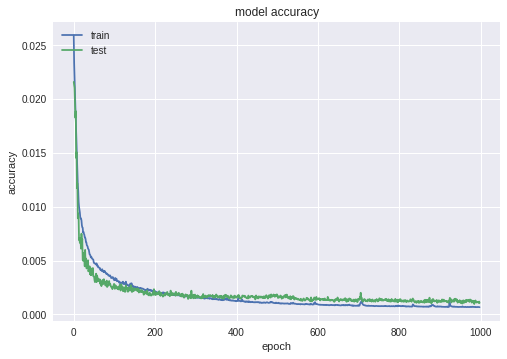

In [97]:
plt.plot(model_history.history['loss'][2:])
plt.plot(model_history.history['val_loss'][2:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("final_model2.hdf5")

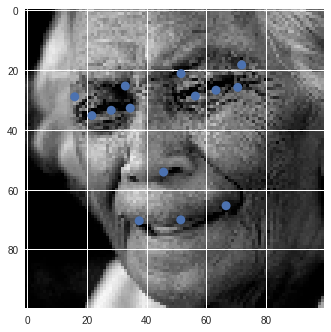

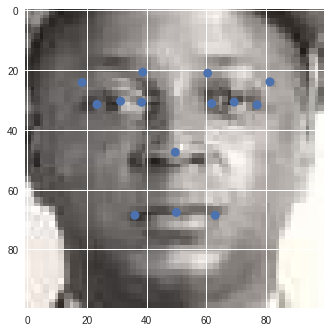

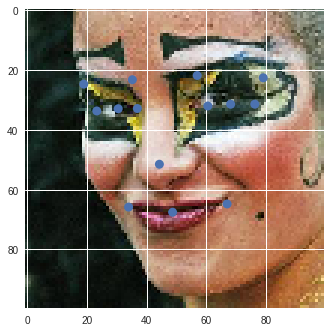

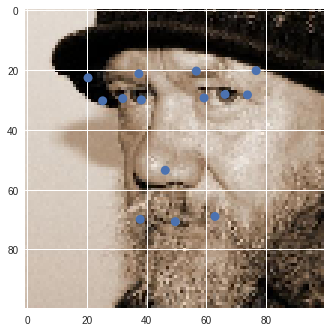

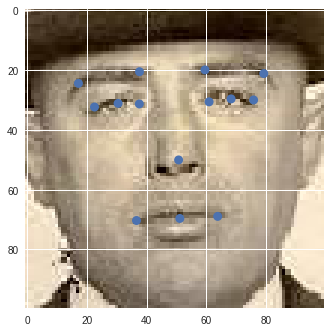

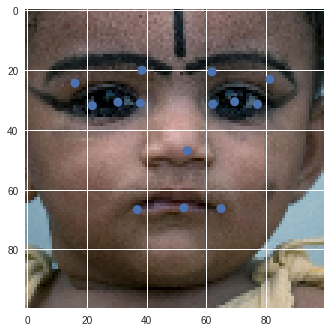

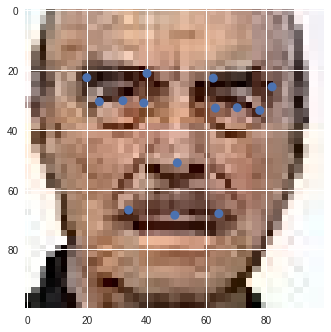

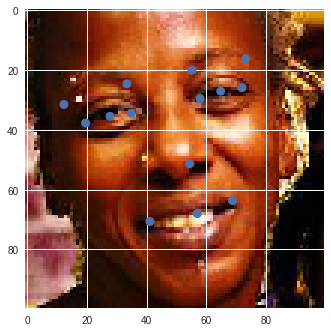

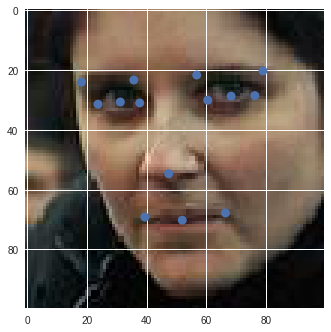

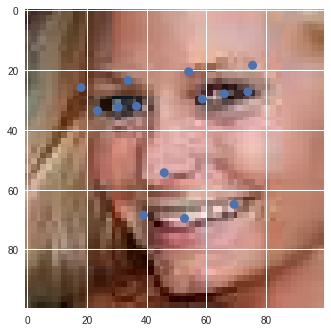

In [101]:
point_val = model.predict(imgs_val)
# Example of output
idx = [2,3,4,5,6,7,8,9,10,11,12,13]
#print(point_val[idx])
for i in range(10):
    visualize_points(imgs_val[idx[i]], point_val[idx[i]])
